In [16]:
%load_ext autoreload
%autoreload 2

import difftet
import torch
import matplotlib.pyplot as plt
import math
import time
from tests.testcases import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
torch.set_default_dtype(difftet.precision)
torch.set_default_device("cuda")
print(difftet.precision)

torch.float64


# Render

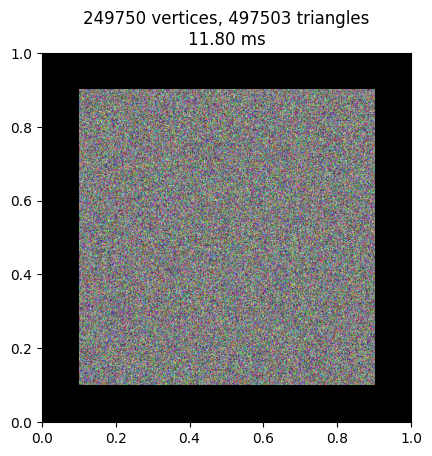

In [19]:
vertices, indices, colors = grid_mesh(500, 500, 0.1, 0.9, 0.1, 0.9)
opacities = torch.ones(vertices.shape[0]) * 0.99
start = time.perf_counter()
im = difftet.render(vertices, indices, colors, opacities)
torch.cuda.synchronize()
im_np = im.cpu().numpy()
end = time.perf_counter()
plt.imshow(im_np.clip(0, 1), extent=[0, 1, 0, 1], origin="lower")
plt.title(f"{vertices.shape[0]} vertices, {indices.shape[0]} triangles\n{(end-start)*1000:.2f} ms")
plt.show()

# Depth sorting test

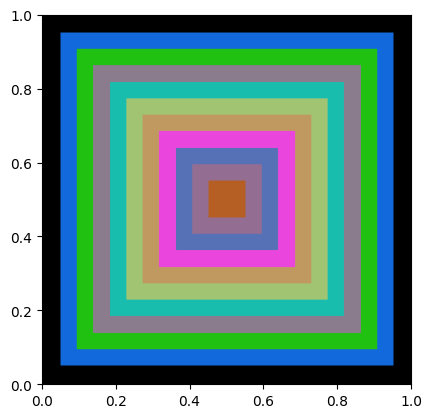

In [4]:
N = 10
vertices = []
indices = []
colors = []
sizes = torch.linspace(0.1, 0.9, N)
vertices, indices, colors = overlapping_squares(N)
opacities = torch.ones(vertices.shape[0])
perm = torch.randperm(indices.shape[0])
indices = indices[perm]

im = difftet.render(vertices, indices, colors, opacities)
im_np = im.cpu().numpy()
plt.imshow(im_np.clip(0, 1), extent=[0, 1, 0, 1], origin="lower")
plt.show()

# Transparency

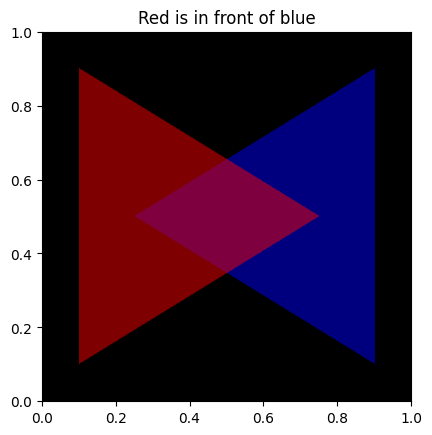

In [5]:
vertices, indices, colors = overlapping_triangles()
opacities = torch.full_like(vertices[:, 0], 0.5)
im = difftet.render(vertices, indices, colors, opacities)
im_np = im.cpu().numpy()
plt.title("Red is in front of blue")
plt.imshow(im_np.clip(0, 1), extent=[0, 1, 0, 1], origin="lower")
plt.show()

# Test early stopping

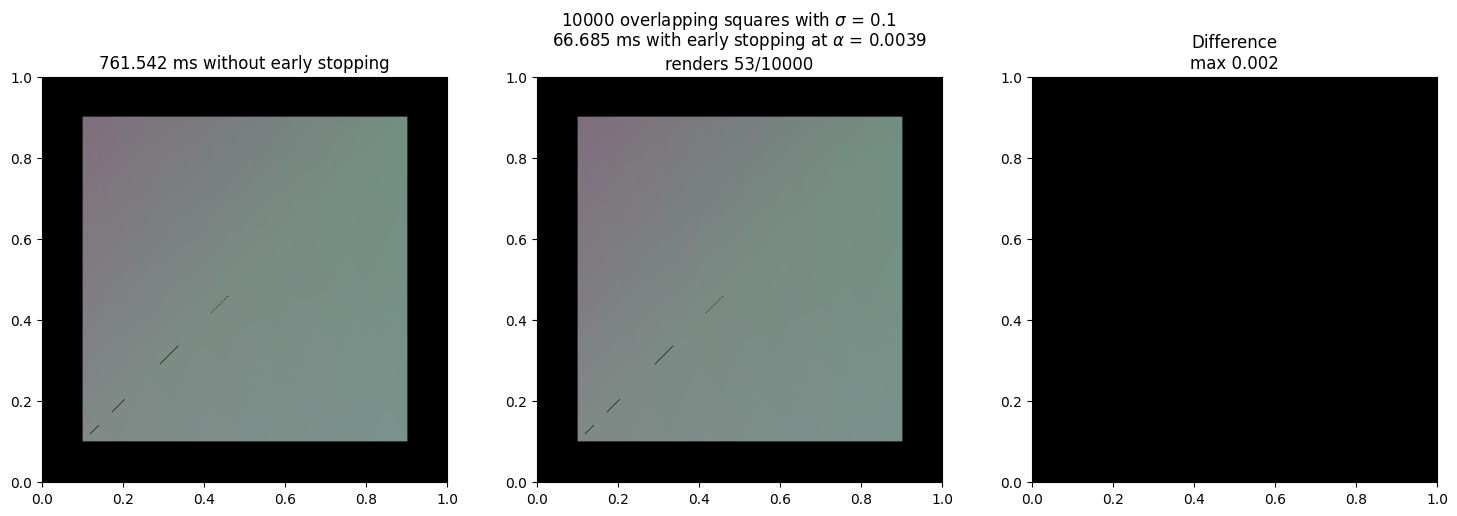

In [6]:
N = 10000
opacity = 0.1
th = 1 / 256
vertices = torch.zeros((N * 4, 4))
vertices[:, 3] = 1.0
vertices[::4, 0] = 0.1
vertices[::4, 1] = 0.1
vertices[1::4, 0] = 0.9
vertices[1::4, 1] = 0.1
vertices[2::4, 0] = 0.9
vertices[2::4, 1] = 0.9
vertices[3::4, 0] = 0.1
vertices[3::4, 1] = 0.9
indices = torch.zeros((N * 2, 3), dtype=torch.int32)
indices[::2, 0] = torch.arange(0, N * 4, 4)
indices[::2, 1] = torch.arange(1, N * 4, 4)
indices[::2, 2] = torch.arange(2, N * 4, 4)
indices[1::2, 0] = torch.arange(0, N * 4, 4)
indices[1::2, 1] = torch.arange(2, N * 4, 4)
indices[1::2, 2] = torch.arange(3, N * 4, 4)
vertices[indices[::2], 2] = torch.linspace(0, 1, N).unsqueeze(1)
vertices[indices[1::2], 2] = torch.linspace(0, 1, N).unsqueeze(1)
colors = torch.rand((N * 4, 3))
opacities = torch.full((N * 4,), opacity)


plt.figure(figsize=(15, 5))
plt.suptitle(f"{N} overlapping squares with $\\sigma$ = {opacity}")
plt.subplot(1, 3, 1)
start = time.perf_counter()
im = difftet.render(vertices, indices, colors, opacities, early_stopping_threshold=0)
im_np1 = im.detach().cpu().numpy()
end = time.perf_counter()
plt.title(f"{(end-start)*1000:.3f} ms without early stopping")
plt.imshow(im_np1, extent=[0, 1, 0, 1], origin="lower")
plt.subplot(1, 3, 2)
start = time.perf_counter()
im = difftet.render(vertices, indices, colors, opacities, early_stopping_threshold=th)
im_np2 = im.detach().cpu().numpy()
end = time.perf_counter()
n_early = int(math.ceil((math.log(th) / math.log(1 - opacity))))
plt.title(f"{(end-start)*1000:.3f} ms with early stopping at $\\alpha$ = {th:.4f}\nrenders {n_early}/{N}")
plt.imshow(im_np2, extent=[0, 1, 0, 1], origin="lower")
plt.subplot(1, 3, 3)
diff = im_np1 - im_np2
diff = diff.clip(0, 1)
plt.title(f"Difference\nmax {diff.max():.3f}")
plt.imshow(diff, extent=[0, 1, 0, 1], origin="lower")

plt.tight_layout()
plt.show()

# Colors Backwards Test

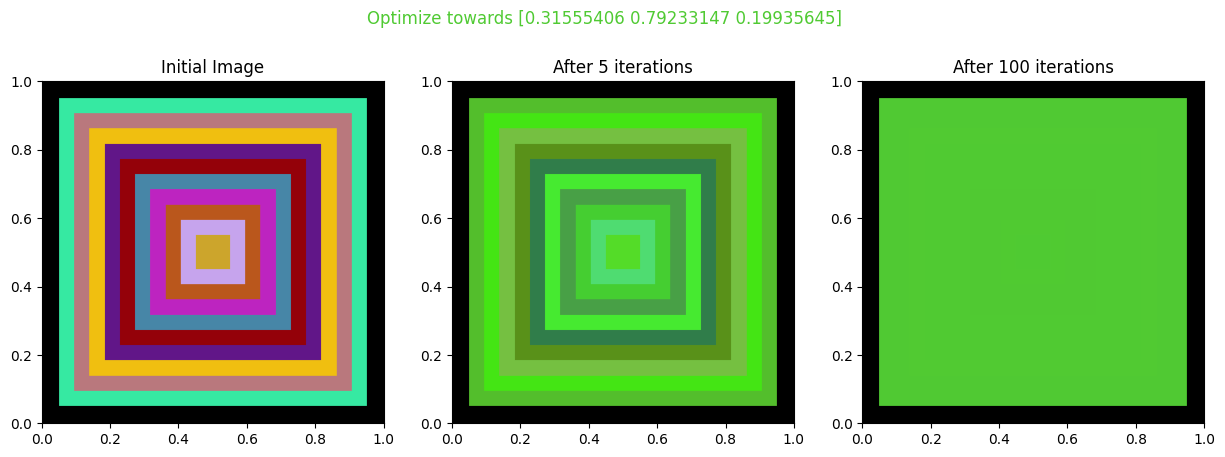

In [7]:
target_color = torch.rand((3,))
vertices, indices, colors = overlapping_squares(10)
opacities = torch.ones(vertices.shape[0])
im = difftet.render(vertices, indices, colors, opacities)
colors.requires_grad_()
im = difftet.render(vertices, indices, colors, opacities)
im_np = im.detach().cpu().numpy().clip(0, 1.0)
plt.figure(figsize=(15, 5))
plt.suptitle(f"Optimize towards {target_color.cpu().numpy()}", color=target_color.cpu().numpy())
plt.subplot(1, 3, 1)
plt.title("Initial Image")
plt.imshow(im_np, extent=[0, 1, 0, 1], origin="lower")
optim = torch.optim.Adam([colors], lr=0.1)
for i in range(5):
    optim.zero_grad()
    im = difftet.render(vertices, indices, colors, opacities)
    loss = torch.mean((im - target_color) ** 2)
    loss.backward()
    optim.step()
with torch.no_grad():
    im = difftet.render(vertices, indices, colors, opacities)
im_np = im.detach().cpu().numpy().clip(0, 1)
plt.subplot(1, 3, 2)
plt.title("After 5 iterations")
plt.imshow(im_np, extent=[0, 1, 0, 1], origin="lower")
for i in range(95):
    optim.zero_grad()
    im = difftet.render(vertices, indices, colors, opacities)
    loss = torch.mean((im - target_color) ** 2)
    loss.backward()
    optim.step()
with torch.no_grad():
    im = difftet.render(vertices, indices, colors, opacities)
im_np = im.detach().cpu().numpy().clip(0, 1)
plt.subplot(1, 3, 3)
plt.title("After 100 iterations")
plt.imshow(im_np, extent=[0, 1, 0, 1], origin="lower")
plt.show()

# Transparency Backwards Test

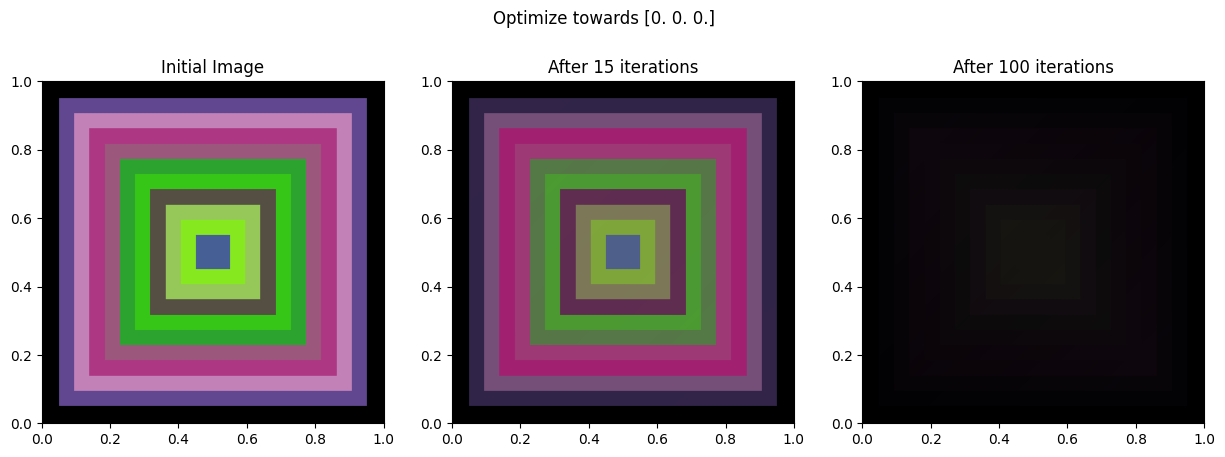

In [8]:
N = 10
target_color = torch.tensor([0.0, 0.0, 0.0])
vertices, indices, colors = overlapping_squares(10)
opacities = torch.ones(vertices.shape[0])
opacities.requires_grad_()
im = difftet.render(vertices, indices, colors, torch.sigmoid(opacities))

im_np = im.detach().cpu().numpy().clip(0, 1.0)
plt.figure(figsize=(15, 5))
plt.suptitle(f"Optimize towards {target_color.cpu().numpy()}")
plt.subplot(1, 3, 1)
plt.title("Initial Image")
plt.imshow(im_np, extent=[0, 1, 0, 1], origin="lower")
optim = torch.optim.Adam([opacities], lr=0.1)
for i in range(15):
    optim.zero_grad()
    im = difftet.render(vertices, indices, colors, torch.sigmoid(opacities))
    loss = torch.mean((im - target_color) ** 2)
    loss.backward()
    optim.step()
with torch.no_grad():
    im = difftet.render(vertices, indices, colors, torch.sigmoid(opacities))
im_np = im.detach().cpu().numpy().clip(0, 1)
plt.subplot(1, 3, 2)
plt.title("After 15 iterations")
plt.imshow(im_np, extent=[0, 1, 0, 1], origin="lower")
for i in range(85):
    optim.zero_grad()
    im = difftet.render(vertices, indices, colors, torch.sigmoid(opacities))
    loss = torch.mean((im - target_color) ** 2)
    loss.backward()
    optim.step()
with torch.no_grad():
    im = difftet.render(vertices, indices, colors, torch.sigmoid(opacities))
im_np = im.detach().cpu().numpy().clip(0, 1)
plt.subplot(1, 3, 3)
plt.title("After 100 iterations")
plt.imshow(im_np, extent=[0, 1, 0, 1], origin="lower")
plt.show()

# Vertices Backwards Test

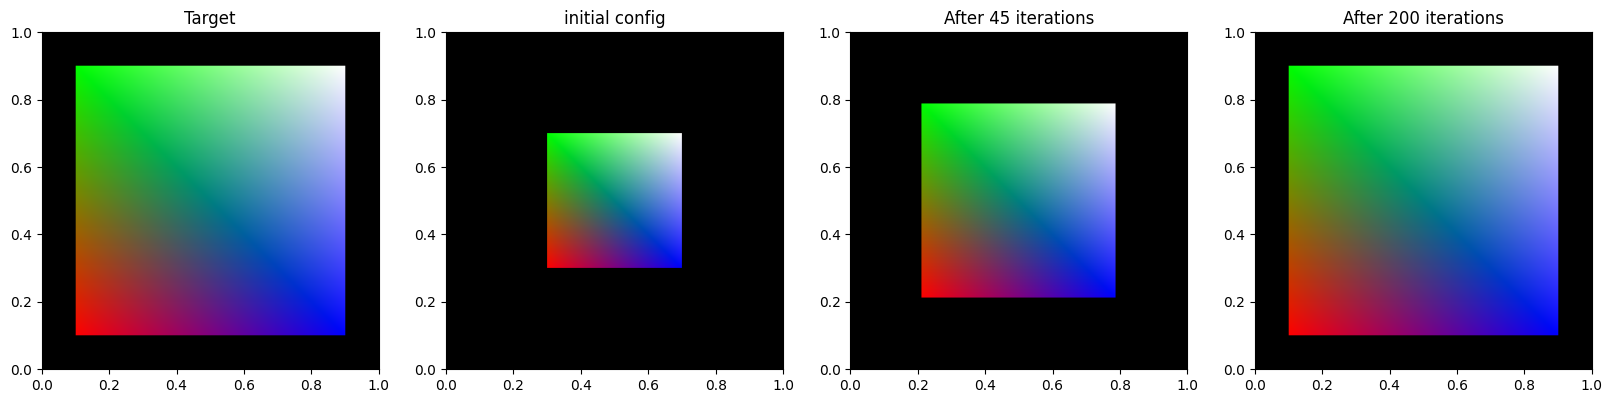

In [21]:
vertices, indices, colors = test_square()
opacities = torch.ones(vertices.shape[0])
im = difftet.render(vertices, indices, colors, opacities)
target = im.detach().clip(0, 1.0)
target_np = target.cpu().numpy()

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.title("Target")
plt.imshow(target_np, extent=[0, 1, 0, 1], origin="lower")
plt.subplot(1, 4, 2)
plt.title("initial config")
vertices[..., 0] = (vertices[..., 0] - 0.5) / 2 + 0.5
vertices[..., 1] = (vertices[..., 1] - 0.5) / 2 + 0.5
# colors = torch.rand_like(colors) * 5 - 2.5
im = difftet.render(vertices, indices, colors, opacities)
im_np = im.detach().cpu().numpy()
plt.imshow(im_np, extent=[0, 1, 0, 1], origin="lower")
plt.subplot(1, 4, 3)
plt.title("After 45 iterations")
vertices.requires_grad_()
optim = torch.optim.Adam([vertices], lr=0.002)
for i in range(45):
    optim.zero_grad()
    im = difftet.render(vertices, indices, colors, opacities)
    loss = torch.mean((im - target) ** 2)
    loss.backward()
    vertices.grad[:, 3] = 0

    optim.step()
with torch.no_grad():
    im = difftet.render(vertices, indices, colors, opacities)
im_np = im.detach().cpu().numpy()
plt.imshow(im_np, extent=[0, 1, 0, 1], origin="lower")
plt.subplot(1, 4, 4)
plt.title("After 200 iterations")
for i in range(155):
    optim.zero_grad()
    im = difftet.render(vertices, indices, colors, opacities)
    loss = torch.mean((im - target) ** 2)
    loss.backward()
    vertices.grad[:, 3] = 0
    optim.step()
with torch.no_grad():
    im = difftet.render(vertices, indices, colors, opacities)
im_np = im.detach().cpu().numpy()
plt.imshow(im_np, extent=[0, 1, 0, 1], origin="lower")
plt.show()